In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# import pandas as pd

# URL of the dataset
url = "https://raw.githubusercontent.com/getnetbogale27/Baacumen-Unsupervised-Learning-Project/refs/heads/main/Dataset/Online_Retail_dataset.csv?token=GHSAT0AAAAAACY5XTINOJINW4RIB7MMIHMWZYRHK6Q"

# Read the CSV file with encoding specified
df = pd.read_csv(url, encoding='ISO-8859-1')

# Display the first few rows of the dataset
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [14]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Filter out negative quantities or unit prices (returns or errors)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


In [15]:
# Create a TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [16]:
# Define the latest date to calculate recency
latest_date = df['InvoiceDate'].max()

# Create the RFM table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (count of unique invoices)
    'TotalPrice': 'sum'  # Monetary (total spending)
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Preview the RFM table
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          1  77183.60
1     12347.0        1          7   4310.00
2     12348.0       74          4   1797.24
3     12349.0       18          1   1757.55
4     12350.0      309          1    334.40


In [17]:
# Apply log transformation to Monetary (optional for reducing skewness)
rfm['Monetary'] = np.log1p(rfm['Monetary'])

# Standardize the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Convert back to DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])


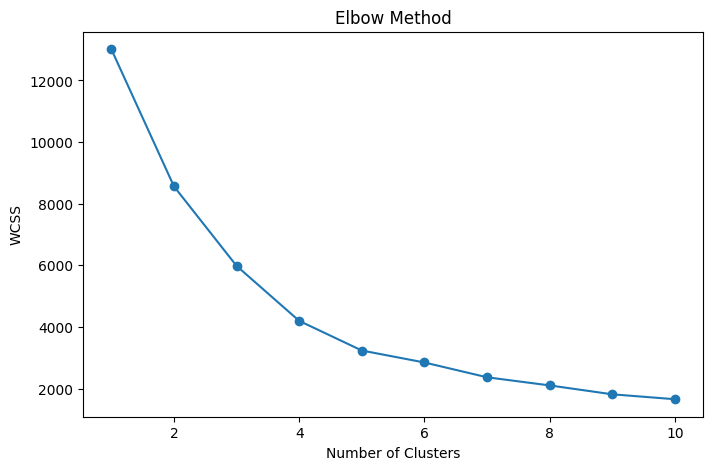

In [18]:
# Elbow method to determine optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [24]:
# Apply K-means with the chosen number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Preview the RFM table with cluster assignments
print(rfm.head())


   CustomerID  Recency  Frequency   Monetary  Cluster
0     12346.0      325          1  11.253955        2
1     12347.0        1          7   8.368925        2
2     12348.0       74          4   7.494564        2
3     12349.0       18          1   7.472245        2
4     12350.0      309          1   5.815324        1


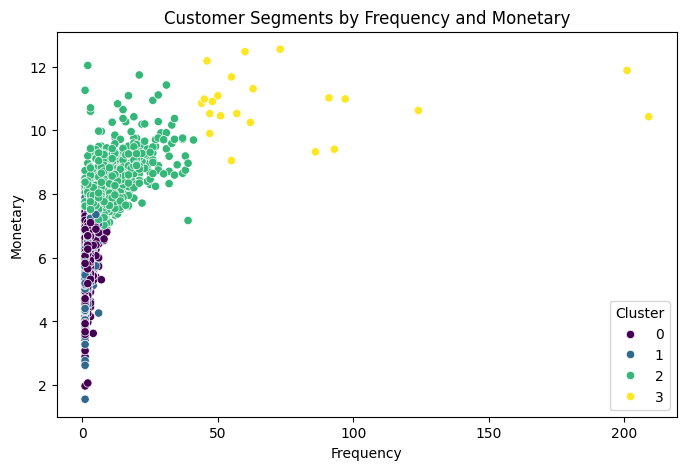

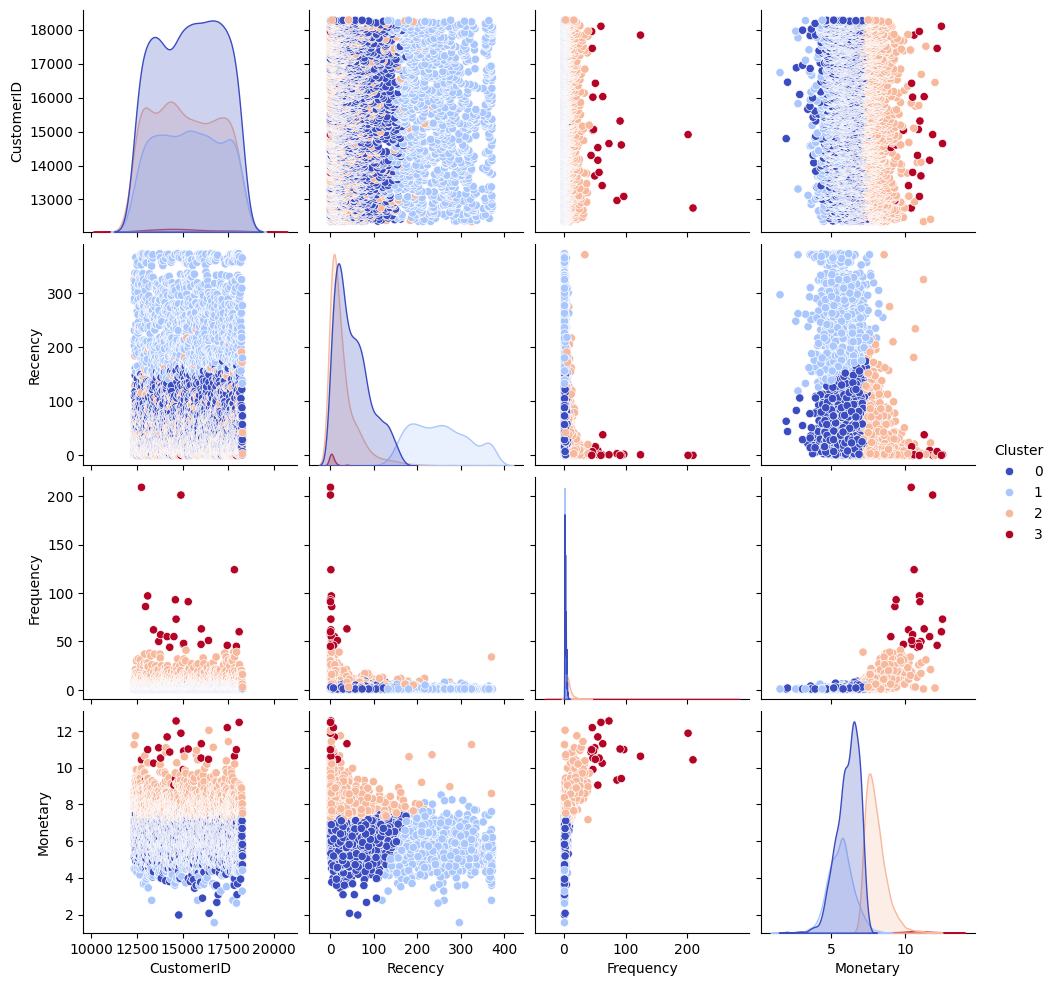

In [25]:
# Scatter plot of Frequency vs Monetary by Cluster
plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Customer Segments by Frequency and Monetary')
plt.show()

# Pairplot of the RFM data by cluster
sns.pairplot(rfm, hue='Cluster', palette='coolwarm')
plt.show()


In [27]:
# Summary statistics for each cluster
cluster_summary = rfm.groupby('Cluster').mean()
print(cluster_summary)


           CustomerID     Recency  Frequency   Monetary
Cluster                                                
0        15363.936377   51.952404   2.196212   6.136318
1        15348.191235  252.365538   1.456175   5.650240
2        15161.350359   29.237829   8.654429   8.026587
3        15094.045455    4.772727  77.454545  10.832794


In [28]:
rfm.to_csv('customer_segments.csv', index=False)